In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from urllib.request import urlopen
import operator
from math import sin, cos, sqrt, atan2, radians

# Identifikujte aktivní a neaktivní stanice

In [2]:
df = pd.read_csv("J:/edinburgh_bikes.csv")

In [3]:
# Zjistit datum poslední výpůjčky. Poté určit hranici, co je ještě aktivní stanice.
activeStations = []

# Uložíme názvy všech stanic
stations = df.start_station_name.unique()

# Vybereme a uložíme pouze stanice, které byly aktivní (sloupec ended_at) alespoň k datu 2020-10-01
for station in stations:
    df_station = df[df.start_station_name == station]
    
    df_station_last_ended = df_station.ended_at.max()
    if df_station_last_ended.split(' ', 1)[0] >= '2020-10-01':
        activeStations.append(station)

In [4]:
# Vytvoříme dataframe pouze s aktivními stanicemi
df_active_stations = df[df['start_station_name'].isin(activeStations)]

# Identifikujte nejfrekventovanější stanice

In [5]:
startStations = {}
endStations = {}
# Z aktivních stanic vybereme stanice, kde výpůjčka kola započala a stanice, kam bylo kolo vráceno
for station in activeStations:
    df_active_start_stations = df_active_stations['start_station_name'] == station
    df_active_end_stations = df_active_stations['end_station_name'] == station
    # Pandas series převedeme do python listu a uložíme pouze druhou (True) hodnotu
    startStations[station] = df_active_start_stations.value_counts().tolist()[1]
    endStations[station] = df_active_end_stations.value_counts().tolist()[1]

In [6]:
# Poté hodnoty vybraných stanic sečteme a získáme tak nejfrekventovanější stanice
mostFrequentStations = {}
for station in activeStations:
    mostFrequentStations[station] = startStations[station] + endStations[station]
# Srovnáme je od nejvyšší hodnoty po nejnižší 
# dict(sorted(mostFrequentStations.items(), key=operator.itemgetter(1), reverse=True))

{'Meadows East': 23412,
 'Victoria Quay': 18784,
 'Portobello - Kings Road': 18103,
 'Bristo Square': 16972,
 'St Andrew Square': 16803,
 'Canonmills': 16050,
 'Meadow Place': 15470,
 'Leith Walk': 15392,
 'Dundee Terrace': 13695,
 'Duke Street': 13575,
 'Castle Street': 13415,
 'Waverley Bridge': 13089,
 'Fountainbridge': 13020,
 'Brunswick Place': 12037,
 'Cramond Foreshore': 11996,
 'Ocean Terminal': 11552,
 'Stockbridge': 11280,
 'Charlotte Square': 10786,
 'Pollock Halls': 10449,
 'George Square': 10108,
 'Tollcross': 9599,
 'South Trinity Road': 9091,
 'Lauriston Place': 8057,
 'Hillside Crescent': 7865,
 'Morningside Road': 7691,
 'Bruntsfield Links': 7537,
 'Inverleith Row': 7403,
 'Causewayside': 7364,
 'Castle Terrace': 7347,
 'Dundas Street': 7346,
 'Royal Commonwealth Pool': 7316,
 'Abbeyhill': 7049,
 'Joppa': 6837,
 'Lothian Road': 6659,
 'City Chambers': 6618,
 'Warrender Park Road': 6607,
 'Dynamic Earth': 6597,
 'Comely Bank Road': 6540,
 'East London Street': 6470,
 'K

# Identifikujte stanice, na kterých se kola hromadí a stanice, kde potenciálně chybí.

In [7]:
# Spočítat rozdíl mezi počtem příjezdů a počtem odjezdů - k tomu potřebujeme sloupce start_station_name, end_station_name
# Převis nabídky nad poptávkou, tzn. zákazníci do dané stanice spíše kola vrací než si je vypůjčují (end_station_name > start_station_name)
# Převis poptávky nad nabídkou, tzn. kola k vypůjčení mohou potencionálně scházet (start_station_name > end_station_name)
allStations = {}
for station in activeStations:
    allStations[station] = startStations[station] - endStations[station]
    
# Převis poptávky nad nabídkou
highDemandStations = dict((key, value) for key, value in allStations.items() if value >= 0)
# Převis nabídky nad poptávkou
highSupplyStations = dict((key, value) for key, value in allStations.items() if value < 0)
# Všechny stanice srovnané od stanic s vysokou poptávkou po stanice s vysokou nabídkou
# dict(sorted(allStations.items(), key=operator.itemgetter(1), reverse=True))

{'Bristo Square': 5026,
 'St Andrew Square': 3941,
 'Charlotte Square': 2882,
 'City Chambers': 2592,
 'Lauriston Place': 2379,
 'Meadows East': 2018,
 'Meadow Place': 1854,
 'Castle Street': 1841,
 'Pollock Halls': 1703,
 'Bruntsfield Links': 1605,
 'St Andrews House': 1156,
 'Lothian Road': 1151,
 'Fountainbridge': 1142,
 'Castle Terrace': 999,
 'Warrender Park Road': 975,
 'West Crosscauseway': 933,
 'Marchmont Crescent': 849,
 'Royal Commonwealth Pool': 792,
 'Surgeons Hall': 714,
 'Colinton Road': 709,
 'EICC': 656,
 'Chambers Street': 633,
 'George Square': 552,
 'Crichton Street': 546,
 'Waverley Station': 541,
 'Waverley Bridge': 449,
 'Thirlestane Road': 401,
 'Waverley Court': 352,
 'Simon Square': 308,
 'Kings Building 3': 305,
 'Hunter Square': 269,
 'Haymarket Station': 268,
 'Tollcross': 265,
 'Drumsheugh Place': 211,
 'Haymarket Terrace': 177,
 'East London Street': 134,
 'Causewayside': 132,
 'Gladstone Terrace': 127,
 'Dundee Terrace': 125,
 'Edinburgh Zoo': 123,
 'Gra

# Spočítejte vzdálenosti mezi jednotlivými stanicemi

In [8]:
stationsCoords = {}

# Vytvoření python dictionary se jmény aktivních stanic a jejich koordináty
for station in activeStations:
    df_stations = df[df['start_station_name'].isin([station])]
    stationsCoords[station] = {}
    stationsCoords[station]['lat'] = df_stations['start_station_latitude'].drop_duplicates().tolist()[0]
    stationsCoords[station]['long'] = df_stations['start_station_longitude'].drop_duplicates().tolist()[0]

In [9]:
# Počítání vzdáleností mezi jednotlivými stanicemi prostřednictvím Haversinova vzorce
j = 0
R = 6373.0

for indexA in range(0, len(activeStations)):
    for indexB in range(j, len(activeStations)):
        if activeStations[indexA] != activeStations[indexB]:  
            
            latA = radians(stationsCoords[activeStations[indexA]]['lat'])
            latB = radians(stationsCoords[activeStations[indexB]]['lat'])
            longA = radians(stationsCoords[activeStations[indexA]]['long'])
            longB = radians(stationsCoords[activeStations[indexB]]['long'])
            
            distanceLat = latA - latB
            distanceLong = longA - longB
            
            a = sin(distanceLat / 2)**2 + cos(latA) * cos(latB) * sin(distanceLong / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            # print('Stanice {} a {} jsou od sebe vzdálené {} kilometrů'.format(activeStations[indexA], activeStations[indexB], distance))
    j += 1

Stanice Charlotte Square a St Andrew Square jsou od sebe vzdálené 0.9317328888598503 kilometrů
Stanice Charlotte Square a Canonmills jsou od sebe vzdálené 1.345211273248909 kilometrů
Stanice Charlotte Square a Kings Building 2 jsou od sebe vzdálené 3.9216867887890325 kilometrů
Stanice Charlotte Square a Kings Buildings 1 jsou od sebe vzdálené 3.7549926589648948 kilometrů
Stanice Charlotte Square a Kings Building 3 jsou od sebe vzdálené 3.7691527671771836 kilometrů
Stanice Charlotte Square a Pollock Halls jsou od sebe vzdálené 2.6052015388404186 kilometrů
Stanice Charlotte Square a Royal Commonwealth Pool jsou od sebe vzdálené 2.543732503741753 kilometrů
Stanice Charlotte Square a Meadows East jsou od sebe vzdálené 2.0600392522953945 kilometrů
Stanice Charlotte Square a Waverley Bridge jsou od sebe vzdálené 0.9827075238605097 kilometrů
Stanice Charlotte Square a City Chambers jsou od sebe vzdálené 1.0777923343963491 kilometrů
Stanice Charlotte Square a Brunswick Place jsou od sebe vzdál

# Jak dlouho trvá jedna výpůjčka?

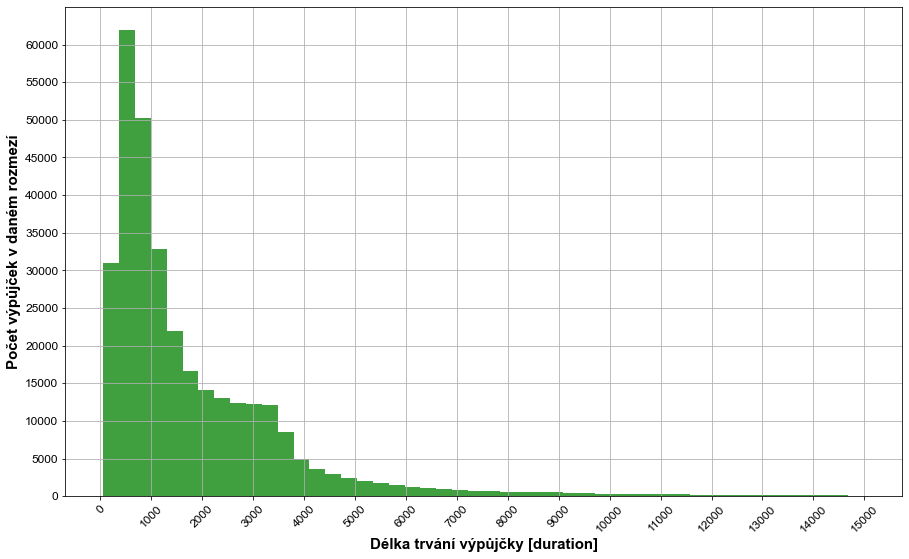

In [10]:
# Najděte odlehlé hodnoty, zobrazte histogram pomocí duration [sec]
df_active_stations = df[df['start_station_name'].isin(activeStations)]
# Z dat byly vyloučeny (duration) hodnoty mezi 15 000 až 1 373 043 sekund (1769 z celkových 320325 hodnot). 
# Zmíněné hodnoty výrazně zkreslovaly histogram.
# Pravděpodobně se jedná o výpůjčky kol, které zákazník zapomněl vrátit v zamýšleném čase.
df_active_stations = df_active_stations[df_active_stations['duration'] <= 15000]

x = df_active_stations['duration'].to_numpy()

fig, ax = plt.subplots(figsize=(15, 9))

n, bins, patches = plt.hist(x, 48, density=False, facecolor='g', alpha=0.75)

plt.ylabel('Počet výpůjček v daném rozmezí', fontsize = 15, weight='bold')
plt.xlabel('Délka trvání výpůjčky [duration]', fontsize = 15, weight='bold')

plt.grid(True)
plt.xticks(np.arange(0, 15001, step=1000), rotation=45, fontsize = 12)
plt.yticks(np.arange(0, 60001, step=5000), fontsize = 12)
plt.style.use('seaborn')

plt.show()

# Zobrazte vývoj poptávky po půjčování kol v čase.

In [11]:
df_active_stations = df[df['start_station_name'].isin(activeStations)]
# Z formátu př.: '2018-09-15 08:52:05.960000+00:00' extrahujeme pouze 2018-09-15
# Pro každé datum vybereme pouze unikátní hodnotu.
df_active_stations['started_at'] = df_active_stations['started_at'].str.split().str[0]
df_demand = list(df_active_stations.started_at.values)
uniqueDates = list(np.unique(df_demand))

tempList = []
dailyDemandDict = {}

for date in uniqueDates:
    dailyDemandDict[date] = {}
    dailyDemandDict[date] = df_demand.count(date)

<ipython-input-11-0977d771825a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_active_stations['started_at'] = df_active_stations['started_at'].str.split().str[0]


In [12]:
# Python dictionary převedeme do pandas dataframe
df_daily_demand = pd.DataFrame.from_dict(dailyDemandDict, orient='index').reset_index()
df_daily_demand = df_daily_demand.rename(columns={"index": "date", 0: "daily_demand"})

In [13]:
# Pro každý rok vytvoříme vlastní dataframe
df_daily_demand_2018 = df_daily_demand[df_daily_demand['date'] <= '2018-12-31']
df_daily_demand_2019 = df_daily_demand[(df_daily_demand['date']> '2018-12-31') & (df_daily_demand['date'] <= '2019-12-31')]
df_daily_demand_2020 = df_daily_demand[df_daily_demand['date'] >= '2020-01-01']

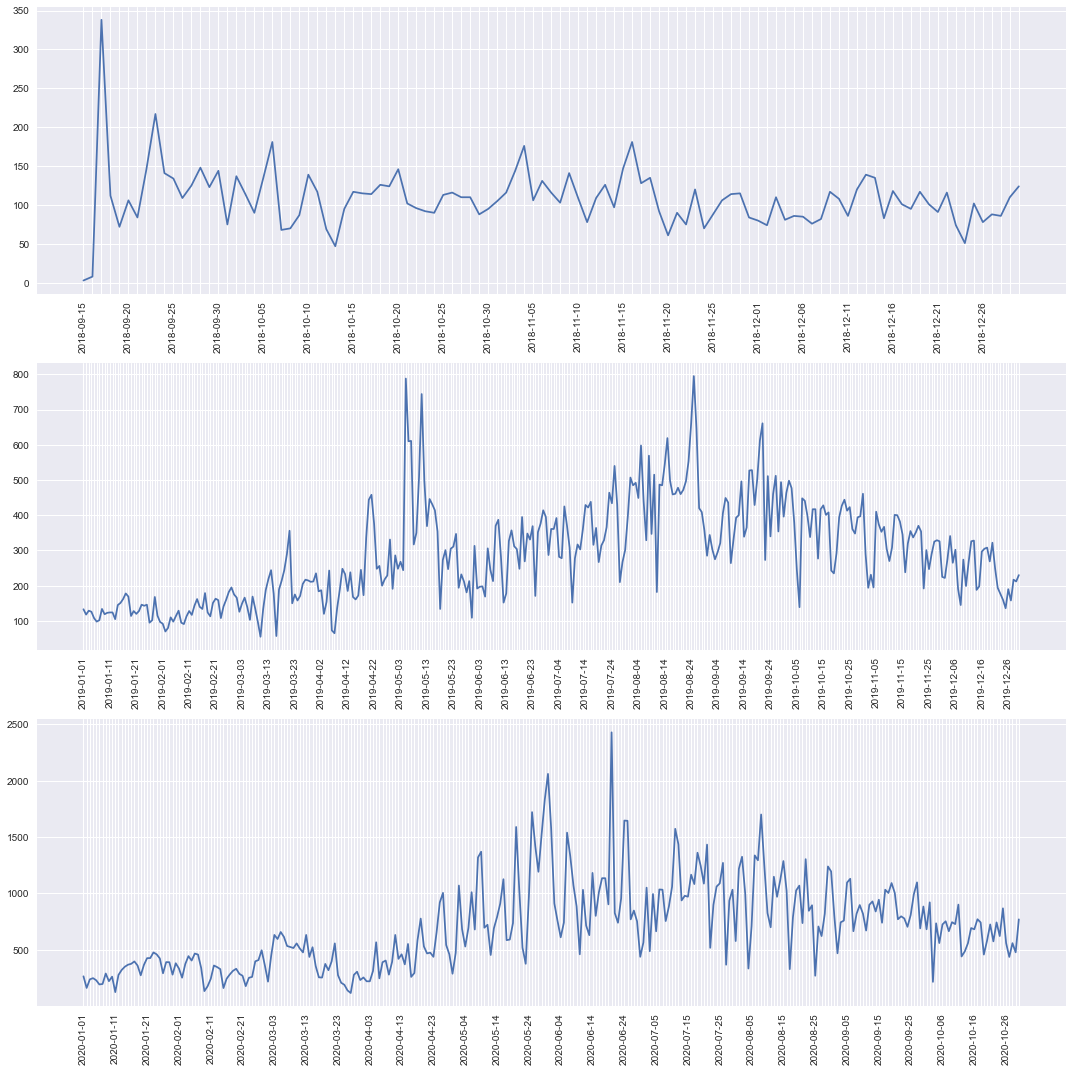

In [14]:
# Vývoj poptávky zobrazíme v plot grafu.
fig1, axs = plt.subplots(ncols=1, nrows=3, figsize=(15,15))

axs[0].plot(df_daily_demand_2018['date'], df_daily_demand_2018['daily_demand'])
axs[1].plot(df_daily_demand_2019['date'], df_daily_demand_2019['daily_demand'])
axs[2].plot(df_daily_demand_2020['date'], df_daily_demand_2020['daily_demand'])

axs[0].set_xticklabels(list(df_daily_demand_2018['date']), rotation=90)
for i, t in enumerate(axs[0].get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)

axs[1].set_xticklabels(list(df_daily_demand_2019['date']), rotation=90)
for i, t in enumerate(axs[1].get_xticklabels()):
    if (i % 10) != 0:
        t.set_visible(False)
        
axs[2].set_xticklabels(list(df_daily_demand_2020['date']), rotation=90)
for i, t in enumerate(axs[2].get_xticklabels()):
    if (i % 10) != 0:
        t.set_visible(False)
        
plt.tight_layout()
plt.show()

# Identifikujte příčiny výkyvů poptávky

# Zjistěte vliv počasí na poptávku po kolech

In [16]:
# temp [°c], feels [°c], wind [km/h], gust [km/h], rain [mm], humidity [%], cloud [%], pressure [mb]
df_weather = pd.read_csv("J:/edinburgh_weather.csv")

In [17]:
colList = ['temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud', 'pressure']

# Z dataframu odstraníme měrné jednotky [°c],[km/h],[mm],[%],[mb] a hodnoty převedeme do numerického formátu (int, float)
for col in colList:
    if col not in ('humidity', 'cloud'):     
        df_weather[col] = pd.to_numeric(df_weather[col].str.split().str[0])
    else:
        df_weather[col] = pd.to_numeric(df_weather[col].str.replace('%', ''))

In [18]:
# Spočítáme průmernou hodnotu pro všechny přírodní jevy za každý den
df_weather = df_weather.groupby('date')[['temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud','pressure']].mean().reset_index()
df_weather

,date,temp,feels,wind,gust,rain,humidity,cloud,pressure
0,2018-09-01,14.375,14.000,12.125,20.125,0.0125,84.875,77.625,1020.875
1,2018-09-02,16.500,16.625,12.875,21.000,0.0500,87.875,70.625,1019.875
2,2018-09-03,11.875,11.500,8.625,13.125,0.0375,87.625,70.750,1023.250
3,2018-09-04,11.250,13.375,5.000,6.750,0.0000,75.125,6.750,1024.375
4,2018-09-05,12.500,12.625,9.375,14.125,0.0500,79.750,27.250,1022.125
...,...,...,...,...,...,...,...,...,...
787,2020-10-27,7.125,4.625,15.250,22.375,0.1250,86.250,54.125,988.625
788,2020-10-28,7.250,3.500,24.500,34.000,0.1500,83.625,87.500,990.125
789,2020-10-29,6.750,5.250,16.875,26.625,1.2625,87.500,84.625,999.000
790,2020-10-30,10.500,8.125,20.500,28.625,0.0875,78.625,62.375,1006.875


In [38]:
# Spojíme dohromady dataframy df_weather a df_daily_demand prostřednictvím klíče 'date'
df_demand_weather = pd.merge(df_weather, df_daily_demand, on=['date'])

In [45]:
# Nakonec zjistíme vliv počasí na poptávku po kolech
df_demand_weather.corr().loc[['daily_demand'], ['temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud', 'pressure']]

,temp,feels,wind,gust,rain,humidity,cloud,pressure
daily_demand,0.49321,0.507477,-0.231825,-0.282444,-0.058927,-0.233228,-0.058043,0.129844


# Půjčují si lidé kola více o víkendu než během pracovního týdne?

In [52]:
import datetime 
import calendar 

df_station_dates = []
weekDays = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0, 'Sunday': 0}

for station in activeStations: 
    df_active_stations = df[df['start_station_name'].isin([station])]
    df_demand = list(df_active_stations.started_at.values)
    
    for i in range(0, len(df_demand)):
        # Upravíme formát data
        df_station_dates.append(df_demand[i].split(' ', 1)[0])
        # Zjistíme jaký den je reprezentován daným datem
        dayNumber = datetime.datetime.strptime(df_station_dates[i], '%Y-%m-%d').weekday()
        # Pojmenujeme výsledný den
        dayName = calendar.day_name[dayNumber]
        weekDays[dayName] += 1

print(weekDays, sum(weekDays.values()))

{'Monday': 47883, 'Tuesday': 45086, 'Wednesday': 49210, 'Thursday': 47623, 'Friday': 46657, 'Saturday': 44819, 'Sunday': 39047} 320325


In [55]:
workingDaysList = "MondayTuesdayWednesdayThursdayFriday" 
weekendDaysList = "SaturdaySunday"

workingDays = sum([value for key, value in weekDays.items() if key in workingDaysList])
weekend = sum([value for key, value in weekDays.items() if key in weekendDaysList])
print("Během sledované doby si zákazníci půjčili kolo v pracovní den: {} a o víkendu {}.".format(workingDays, weekend))

Během sledované doby si zákazníci půjčili kolo v pracovní den: 236459 a o víkendu 83866.
